In [1]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
module_path = '/home/jupyter-ayoub'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [3]:
#ssrd6
test_rfcs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_observation.nc")

In [4]:
#obs w10
obs_w10=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_observation.nc")

In [5]:
#obs t2m
obs_t2m=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_observation.nc")

In [6]:
#obs ssrd6
obs_ssrd6=xr.open_dataset("/home/jupyter-ayoub/data/test/test_observation.nc")

In [7]:
test_rfcs=test_rfcs
obs=obs
obs_w10=obs_w10
obs_t2m=obs_t2m
obs_ssrd6=obs_ssrd6

In [8]:
print(obs_ssrd6)

<xarray.Dataset> Size: 35MB
Dimensions:     (time: 209, number: 1, step: 20, surface: 1, latitude: 32,
                 longitude: 33)
Coordinates:
  * latitude    (latitude) float64 256B 53.5 53.25 53.0 ... 46.25 46.0 45.75
  * longitude   (longitude) float64 264B 2.5 2.75 3.0 3.25 ... 10.0 10.25 10.5
  * number      (number) int64 8B 0
  * step        (step) float64 160B 6.0 12.0 18.0 24.0 ... 108.0 114.0 120.0
  * surface     (surface) float64 8B 0.0
  * time        (time) datetime64[ns] 2kB 2017-01-02 2017-01-05 ... 2018-12-31
    valid_time  (time, step) datetime64[ns] 33kB ...
    year        int64 8B ...
Data variables:
    ssrd6_obs   (time, number, step, surface, latitude, longitude) float64 35MB ...


In [9]:
tar1='w10'
tar2='t2m'
tar3='ssrd6_obs' 

In [10]:
target='ssrd6_obs'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars(['sd', 'mx2t6', 'mn2t6', 'q', 'ssr6', 'str6'])
#test_rfcs=test_rfcs.drop_vars(['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'tp6', 'ssr6', 'str6', 'strd6'])
#test_rfcs=test_rfcs.drop_vars(['u10', 'v10', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'ssr6', 'str6']) #8
#[ 'sd', 'mx2t6', 'mn2t6', 'q', 'ssr6', 'str6']
#['sd', 'mx2t6', 'mn2t6', 'q', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']

In [11]:
obs_w10=obs_w10[tar1]
obs_t2m=obs_t2m[tar2]
obs_ssrd6=obs_ssrd6[tar3]

In [12]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [13]:
fcs_10=xr.merge([test_rfcs,final_oro])
dummy=xr.merge([test_rfcs,final_oro])

In [14]:
#normalizing met oro.nc
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800),"ssr6":(0,3200000),"ssrd6":(-5200.0,18541902.0),"strd6":(2103856,9537712),"tp6":(-4,1),"ssr6":(-4220.0,15344816.0),"str6":(-4630656.0,1093968.0)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds



dummy_norm=minmax_normalize(dummy,min_max_values)
fcs_norm=dummy_norm

In [15]:
%reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 32, 33, 18), n_heads=8,mlp_mult=4,projection_channels=64)

In [16]:
#this is where the last run is stored 
checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/ssrd6/Beste_result/epochs50predictors18CRPSKERNELSTEPlambda0.02k3.3.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1552161


In [17]:
#turn the normalized reforecasts into a tensor
fcs_norm_whole= fcs_norm.to_array(dim='variable')
print(fcs_norm_whole.sizes)
#print(fcs_norm_whole)
print(fcs_norm_whole.shape)
rearranged_10= fcs_norm_whole.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

Frozen({'variable': 18, 'time': 209, 'number': 11, 'step': 20, 'latitude': 32, 'longitude': 33})
(18, 209, 11, 20, 32, 33)
torch.Size([209, 11, 20, 32, 33, 18])


In [18]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 32, 33, 18])


In [19]:
MBM_one=np.empty((209,11,20,32,33),dtype=float)
for i in range(20):
    mbm1=np.load(f"/home/jupyter-ayoub/ClassicalMBM/resultsClassicalMBM/{target}/MBM_{target}_{i}.npy")
    MBM_one[:,:,i,:,:]=mbm1.squeeze()

In [20]:
postpro_10_whole = torch.empty((209,11,20,32,33,1))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        #print(fcs_whole_tensor[i:end].shape)
        #print(postpro_10_whole[i:end].shape)
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [21]:
# Extract ensemble forecasts
ensemble_one = postpro_10_whole[...,0]

# Compute standard deviation & mean across ensemble dimension (dim=1)
scale_std, scale_mean = torch.std_mean(fcs_whole_notnorm_tensor[..., 15], dim=1, unbiased=True)

# Function to scale and clamp ensemble data
def scale_and_clamp(ensemble):
    scaled = ensemble * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)
    return torch.clamp(scaled, min=1e-6).permute(1, 0, 2, 3, 4)

# Apply scaling and clamping
scaled_ensemble_one = scale_and_clamp(ensemble_one)

In [22]:
# Define coordinates with member first
coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}


# Define dimensions with member first
dims_forecast = ('member', 'time', 'step', 'latitude', 'longitude')

# Convert numpy arrays to xarray DataArray with the specified order
MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)

# Compute mean and std across the member dimension
mean_one = full_ensemble_one.mean(dim='member')
std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

In [23]:
#ALL ENSEMBLES
Tformer_one=full_ensemble_one
MBM_one = MBM_one
Raw = raw_fcs['ssrd6']

#

In [24]:
obs=obs.squeeze()

In [25]:
obs_ssrd6=obs_ssrd6.squeeze()

In [26]:
obs_t2m=obs_t2m.squeeze()

In [27]:
obs_w10=obs_w10.squeeze()

In [ ]:
# Opslaan
np.save("/home/jupyter-ayoub/results/energie/ssrd6/Tformer_one.npy", Tformer_one)
np.save("/home/jupyter-ayoub/results/energie/ssrd6/MBM_one.npy", MBM_one)
np.save("/home/jupyter-ayoub/results/energie/ssrd6/Raw_ssrd6.npy", Raw)
np.save("/home/jupyter-ayoub/results/energie/ssrd6/obs.npy", obs)

In [ ]:
Tformer_one = np.load("/home/jupyter-ayoub/results/energie/ssrd6/Tformer_one.npy")
MBM_one = np.load("/home/jupyter-ayoub/results/energie/ssrd6/MBM_one.npy")
Raw = np.load("/home/jupyter-ayoub/results/energie/ssrd6/Raw_ssrd6.npy")
sv_obs = np.load("/home/jupyter-ayoub/results/energie/ssrd6/obs.npy")

In [28]:
t2m_mean = np.load("/home/jupyter-aaron/Postprocessing/PP_EUPP/results/Plots_t2m/TF_mu 1.npy")
t2m_std = np.load("/home/jupyter-aaron/Postprocessing/PP_EUPP/results/Plots_t2m/TF_std 1.npy")
print(t2m_mean.shape,t2m_std.shape)

(209, 20, 32, 33) (209, 20, 32, 33)


In [29]:
w10_ensemble = np.load("/home/jupyter-aaron/Postprocessing/PP_EUPP/results/Plots_w10/epochs15predictors9CRPSKERNELSTEPlambda0.0275k2.7_nodecayepochs/postprocessed_ensemble.npy")
w10_mean = w10_ensemble.mean(axis=0)
print(w10_ensemble.shape,w10_mean.shape)

(11, 209, 20, 32, 33) (209, 20, 32, 33)


In [30]:
ssrd6_mean = Tformer_one.mean(axis=0)

In [31]:
import torch

def pv_power_jerez(
    tas: torch.Tensor,      # temperatuur op 2m hoogte (°C)
    rsds: torch.Tensor,     # inkomende kortgolvige straling (W/m²)
    vws: torch.Tensor,      # windsnelheid op 10m hoogte (m/s)
    nip: float = 1e6        # nominale geïnstalleerde capaciteit in W (default 1 MW)
) -> torch.Tensor:
    """
    Bereken PV-productie met temperatuur- en windcorrectie volgens Jerez et al. (2015),
    zoals gebruikt in de Dunkelflaute-paper (supplementary materials).
    
    Parameters:
    - tas (torch.Tensor): 2m luchttemperatuur in °C
    - rsds (torch.Tensor): inkomende zonnestraling in W/m²
    - vws (torch.Tensor): windsnelheid op 10m hoogte in m/s
    - nip (float): nominale capaciteit (W); default 1 MW
    
    Returns:
    - torch.Tensor: geschatte PV-productie in Watt (zelfde shape als inputs)
    """

    # Constants
    T_STC = 25.0                       # standaard temperatuur in °C
    RSDS_STC = 1000.0                 # standaard zonnestraling in W/m²
    gamma = 0.005                     # temperatuurcoëfficiënt in °C⁻¹

    # Coëfficiënten voor T_cell schatting
    c1 = 4.3
    c2 = 0.943
    c3 = 0.028   # °C·m²/W
    c4 = -1.528  # °C·s/m

    # Stap 1: Bereken paneeltemperatuur
    T_cell = c1 + c2 * tas + c3 * rsds + c4 * vws

    # Stap 2: Bereken pr(t)
    pr = 1.0 + gamma * (T_cell - T_STC)

    # Stap 3: PV_potentieel
    pv_pot = (pr * rsds) / RSDS_STC

    # Stap 4: Vermogen in Watt
    power_pv = nip * pv_pot

    return power_pv

In [48]:
pv_output_tf = pv_power_jerez(t2m_mean, ssrd6_mean/21600, w10_mean)

In [49]:
pv_output_obs = pv_power_jerez(obs_t2m, obs_ssrd6/21600, obs_w10)

In [50]:
pv_output_raw = pv_power_jerez(raw_fcs['t2m'].mean(axis=0), raw_fcs['ssrd6'].mean(axis=0)/21600, raw_fcs['w10'].mean(axis=0))

In [51]:
pv_output_tf

<xarray.DataArray (time: 209, step: 20, latitude: 32, longitude: 33)> Size: 18MB
array([[[[4.15072421e-08, 4.15072492e-08, 4.15072527e-08, ...,
          4.15073167e-08, 4.15073167e-08, 4.15073167e-08],
         [4.15072456e-08, 4.15072492e-08, 4.15072492e-08, ...,
          4.15073167e-08, 4.15073131e-08, 4.15073131e-08],
         [4.15072527e-08, 4.15072527e-08, 4.15072527e-08, ...,
          4.15073202e-08, 4.15073167e-08, 4.15073167e-08],
         ...,
         [4.15074020e-08, 4.15074055e-08, 4.15074233e-08, ...,
          4.15073238e-08, 4.15073202e-08, 4.15073167e-08],
         [4.15073842e-08, 4.15073877e-08, 4.15074197e-08, ...,
          4.15073416e-08, 4.15073274e-08, 4.15073345e-08],
         [4.15073629e-08, 4.15073735e-08, 4.15074091e-08, ...,
          4.15073629e-08, 4.15073735e-08, 4.15073877e-08]],

        [[1.17863828e+04, 1.11543154e+04, 1.00587354e+04, ...,
          2.49854824e+04, 2.53321074e+04, 2.55080723e+04],
         [1.43909717e+04, 1.41514209e+04, 1.37412002e+04, ...,
          2.84414336e+04, 2.81928906e+04, 2.71533398e+04],
         [1.25931143e+04, 1.24585723e+04, 1.33803525e+04, ...,
          2.93441309e+04, 2.82610723e+04, 2.75431348e+04],
...
          9.27060312e+04, 9.01120547e+04, 9.47720781e+04],
         [2.30509199e+04, 2.32043027e+04, 2.36503262e+04, ...,
          1.06109797e+05, 1.04640742e+05, 1.08120234e+05],
         [2.32084023e+04, 2.40094141e+04, 2.53757949e+04, ...,
          1.03511680e+05, 1.06578898e+05, 1.08151312e+05]],

        [[4.15073131e-08, 4.15073096e-08, 4.15073096e-08, ...,
          4.15073700e-08, 4.15073700e-08, 4.15073735e-08],
         [4.15073096e-08, 4.15073096e-08, 4.15073060e-08, ...,
          4.15073664e-08, 4.15073664e-08, 4.15073700e-08],
         [4.15073096e-08, 4.15073060e-08, 4.15072989e-08, ...,
          4.15073664e-08, 4.15073664e-08, 4.15073700e-08],
         ...,
         [4.15074162e-08, 4.15074162e-08, 4.15074268e-08, ...,
          4.15073309e-08, 4.15073096e-08, 4.15072954e-08],
         [4.15074055e-08, 4.15074055e-08, 4.15074268e-08, ...,
          4.15073202e-08, 4.15073096e-08, 4.15073060e-08],
         [4.15073913e-08, 4.15073913e-08, 4.15074197e-08, ...,
          4.15073629e-08, 4.15073629e-08, 4.15073735e-08]]]],
      shape=(209, 20, 32, 33), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2017-01-02 2017-01-05 ... 2018-12-31
  * step       (step) float64 160B 6.0 12.0 18.0 24.0 ... 108.0 114.0 120.0
  * latitude   (latitude) float64 256B 53.5 53.25 53.0 ... 46.25 46.0 45.75
  * longitude  (longitude) float64 264B 2.5 2.75 3.0 3.25 ... 10.0 10.25 10.5

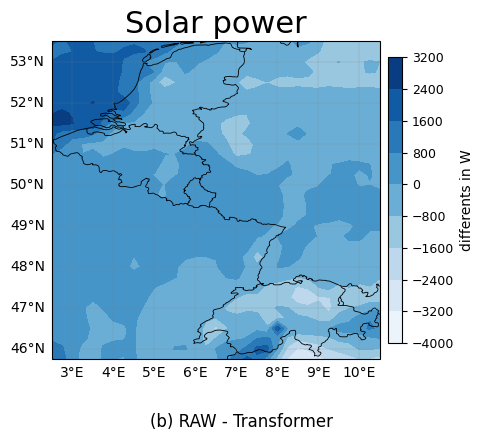

In [52]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = Tformer_one.longitude.values  # of .lon
lats = Tformer_one.latitude.values

TF_1 = pv_output_tf.mean(axis=(0, 1))
OG = pv_output_raw.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  OG - TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, diff, cmap='Blues',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('Solar power', fontsize=22)
plt.figtext(0.5, -0.08, r"(b) RAW - Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

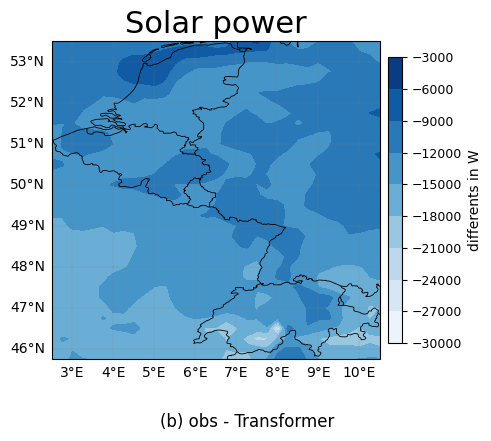

In [53]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = Tformer_one.longitude.values  # of .lon
lats = Tformer_one.latitude.values

TF_1 = pv_output_tf.mean(axis=(0, 1))
OG = pv_output_obs.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  OG - TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, diff, cmap='Blues',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('Solar power', fontsize=22)
plt.figtext(0.5, -0.08, r"(b) obs - Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

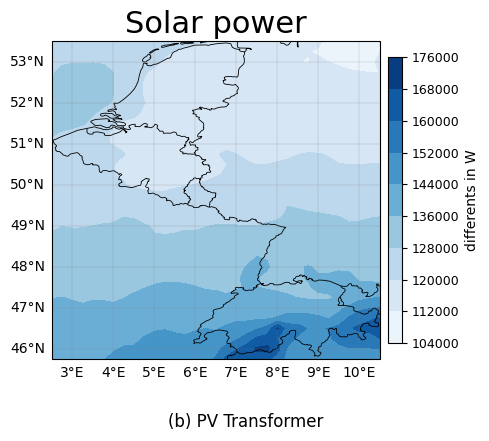

In [58]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = Tformer_one.longitude.values  # of .lon
lats = Tformer_one.latitude.values

TF_1 = pv_output_tf.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS


# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, TF_1, cmap='Blues',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('Solar power', fontsize=22)
plt.figtext(0.5, -0.08, r"(b) PV Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

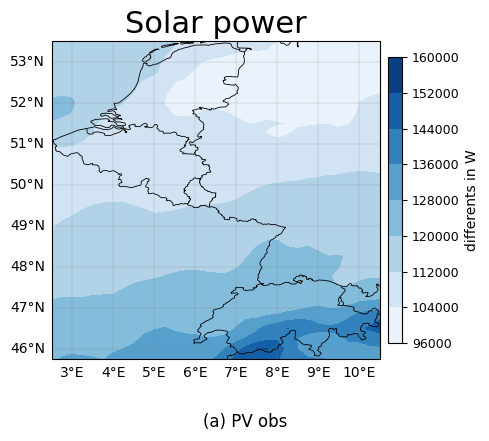

In [59]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = Tformer_one.longitude.values  # of .lon
lats = Tformer_one.latitude.values

OBS = pv_output_obs.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS


# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, OBS, cmap='Blues',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('Solar power', fontsize=22)
plt.figtext(0.5, -0.08, r"(a) PV obs", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

In [1]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = Tformer_one.longitude.values  # of .lon
lats = Tformer_one.latitude.values

OBS = pv_output_raw.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS


# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, OBS, cmap='YlOrBr',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('Solar power', fontsize=22)
plt.figtext(0.5, -0.08, r"(c) PV RAW", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

NameError: name 'Tformer_one' is not defined